# Using CNN  on a small MNIST data set

In this script we build a small CNN with 1 convolutional layer and 1 dense layer. Like in the experiments with the fully connected NN with MNIST that we performed last time, we use again a small data with only 2400 images in the training data set so that the NN can be trained on the CPU.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import time
import tensorflow as tf
tf.set_random_seed(1)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Flatten
import keras
import sys
print ("Keras {} TF {} Python {}".format(keras.__version__, tf.__version__, sys.version_info))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Keras 2.1.4 TF 1.6.0 Python sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_train=x_train[0:2400]
Y_train=y_train[0:2400]

X_val=x_train[2400:3000]
Y_val=y_train[2400:3000]

X_test=x_test[0:1000]
Y_test=y_test[0:1000]

del x_train, y_train, x_test, y_test


In [3]:
X_train=np.reshape(X_train, (2400,28,28,1))
X_val=np.reshape(X_val, (600,28,28,1))
X_test=np.reshape(X_test, (1000,28,28,1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2400, 28, 28, 1)
(600, 28, 28, 1)
(1000, 28, 28, 1)


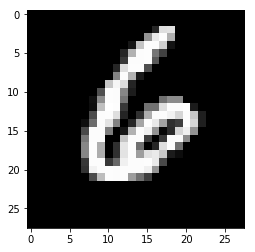

In [4]:
plt.imshow(X_train[13,:,:,0],cmap="gray")

In [5]:
pd.DataFrame(np.hstack((np.transpose(np.unique(Y_train,return_counts=True)),
                        np.transpose(np.unique(Y_val,return_counts=True)),
                        np.transpose(np.unique(Y_test,return_counts=True)))),
                        columns=["train_label","#train_examples",
                                 "val_label","#val_examples",
                                 "test_label","#test_examples"])

,train_label,#train_examples,val_label,#val_examples,test_label,#test_examples
0,0,225,0,60,0,85
1,1,265,1,74,1,126
2,2,238,2,61,2,116
3,3,231,3,64,3,107
4,4,263,4,62,4,110
5,5,219,5,55,5,87
6,6,243,6,63,6,87
7,7,265,7,64,7,99
8,8,213,8,48,8,89
9,9,238,9,49,9,94


In [6]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='float32')
    result[np.arange(len(vector)), vector] = 1
    return result
print("class label")
print(Y_train[0:5])
print("class label in OneHot encodig")
print(convertToOneHot(Y_train[0:5], 10))

class label
[5 0 4 1 9]
class label in OneHot encodig
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [7]:
Y_train=convertToOneHot(Y_train,num_classes=10)
print(Y_train.shape)
Y_val=convertToOneHot(Y_val,num_classes=10)
print(Y_val.shape)

(2400, 10)
(600, 10)


## CNN without standardizing the data 


In [8]:
## here is the code to center and standardize the data
## lets try what happens without centering...
#X_mean = np.mean( X_train, axis = 0)
#X_std = np.std( X_train, axis = 0)

#X_train = (X_train - X_mean ) / (X_std + 0.0001)
#X_val = (X_val - X_mean ) / (X_std + 0.0001)

In [9]:
### First model with a convolutional layer
name = 'cnn1'
model = Sequential()

model.add(Convolution2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                250890    
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________


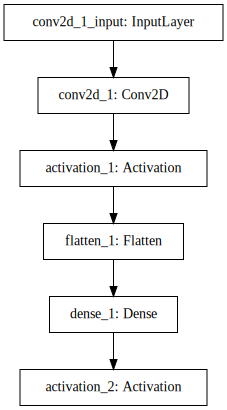

In [11]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
model.evaluate(X_train,Y_train)

2400/2400 [==============================] - 1s 374us/step


[13.565380922953288, 0.07625]

In [13]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/mnist/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [14]:
history=model.fit(X_train, Y_train, 
                  batch_size=128, 
                  epochs=30,
                  verbose=2, 
                  validation_data=(X_val, Y_val),
                  callbacks=[tensorboard])

Train on 2400 samples, validate on 600 samples
Epoch 1/30
 - 3s - loss: 8.7486 - acc: 0.4387 - val_loss: 7.3257 - val_acc: 0.5350
Epoch 2/30
 - 2s - loss: 7.1813 - acc: 0.5508 - val_loss: 7.0342 - val_acc: 0.5600
Epoch 3/30
 - 2s - loss: 6.7524 - acc: 0.5775 - val_loss: 6.4392 - val_acc: 0.5967
Epoch 4/30
 - 2s - loss: 6.5573 - acc: 0.5917 - val_loss: 6.8144 - val_acc: 0.5750
Epoch 5/30
 - 2s - loss: 6.5619 - acc: 0.5900 - val_loss: 6.5996 - val_acc: 0.5867
Epoch 6/30
 - 2s - loss: 6.5431 - acc: 0.5921 - val_loss: 6.5573 - val_acc: 0.5917
Epoch 7/30
 - 3s - loss: 6.9078 - acc: 0.5663 - val_loss: 7.4621 - val_acc: 0.5317
Epoch 8/30
 - 2s - loss: 6.8220 - acc: 0.5738 - val_loss: 6.7065 - val_acc: 0.5800
Epoch 9/30
 - 2s - loss: 6.3452 - acc: 0.6042 - val_loss: 6.6361 - val_acc: 0.5883
Epoch 10/30
 - 2s - loss: 6.6473 - acc: 0.5862 - val_loss: 6.6900 - val_acc: 0.5850
Epoch 11/30
 - 2s - loss: 6.5163 - acc: 0.5933 - val_loss: 6.3235 - val_acc: 0.6067
Epoch 12/30
 - 2s - loss: 6.6454 - acc

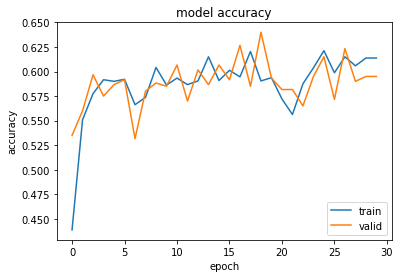

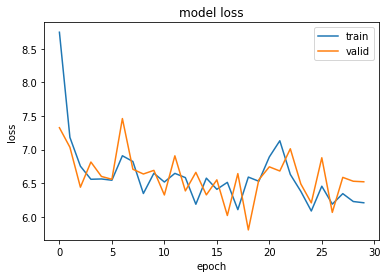

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## Prediction on the test set


In [16]:
pred=model.predict(X_test)
print(confusion_matrix(Y_test,np.argmax(pred,axis=1)))
print("Acc = " ,np.sum(Y_test==np.argmax(pred,axis=1))/len(pred))

[[ 82   0   0   1   1   0   0   0   1   0]
 [  0  95   0   1   0   1   0   0  29   0]
 [  3   1   0  36   5   0   0   2  69   0]
 [  0   0   0  92   1   4   0   1   9   0]
 [  0   0   0   2 101   3   0   0   4   0]
 [  2   0   0   8   3  61   0   4   9   0]
 [ 15   0   0   0  45   7   0   0  20   0]
 [  1   0   0   8   2   0   0  82   6   0]
 [  0   0   0   4   3   0   0   3  79   0]
 [  0   0   0   6  19   1   0  40  28   0]]
Acc =  0.592


In [17]:
del model

## CNN with standardizing the data 


In [18]:
## here is the code to center and standardize the data
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train_norm = np.array((X_train - X_mean ) / (X_std + 0.0001),dtype="float32")
X_val_norm = np.array((X_val - X_mean ) / (X_std + 0.0001),dtype="float32")

In [19]:
### First model with a convolutional layer
name = 'cnn1_norm'
model = Sequential()

model.add(Convolution2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

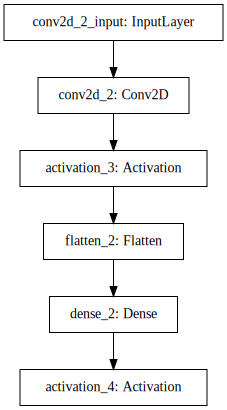

In [20]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [21]:
model.evaluate(X_train_norm,Y_train)

2400/2400 [==============================] - 1s 413us/step


[2.315552193323771, 0.09166666666666666]

In [22]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/mnist/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [23]:
history=model.fit(X_train_norm, Y_train, 
                  batch_size=128, 
                  epochs=30,
                  verbose=2, 
                  validation_data=(X_val_norm, Y_val),
                  callbacks=[tensorboard])

Train on 2400 samples, validate on 600 samples
Epoch 1/30
 - 3s - loss: 0.8409 - acc: 0.7571 - val_loss: 0.5348 - val_acc: 0.8683
Epoch 2/30
 - 2s - loss: 0.2903 - acc: 0.9104 - val_loss: 0.5464 - val_acc: 0.8767
Epoch 3/30
 - 3s - loss: 0.2004 - acc: 0.9437 - val_loss: 0.4696 - val_acc: 0.9033
Epoch 4/30
 - 2s - loss: 0.1339 - acc: 0.9642 - val_loss: 0.4615 - val_acc: 0.9100
Epoch 5/30
 - 2s - loss: 0.1037 - acc: 0.9746 - val_loss: 0.4526 - val_acc: 0.9217
Epoch 6/30
 - 2s - loss: 0.0718 - acc: 0.9850 - val_loss: 0.4328 - val_acc: 0.9183
Epoch 7/30
 - 2s - loss: 0.0518 - acc: 0.9908 - val_loss: 0.4393 - val_acc: 0.9200
Epoch 8/30
 - 2s - loss: 0.0398 - acc: 0.9950 - val_loss: 0.4413 - val_acc: 0.9250
Epoch 9/30
 - 2s - loss: 0.0304 - acc: 0.9963 - val_loss: 0.4386 - val_acc: 0.9217
Epoch 10/30
 - 2s - loss: 0.0210 - acc: 0.9996 - val_loss: 0.4379 - val_acc: 0.9217
Epoch 11/30
 - 2s - loss: 0.0167 - acc: 0.9996 - val_loss: 0.4436 - val_acc: 0.9233
Epoch 12/30
 - 3s - loss: 0.0126 - acc

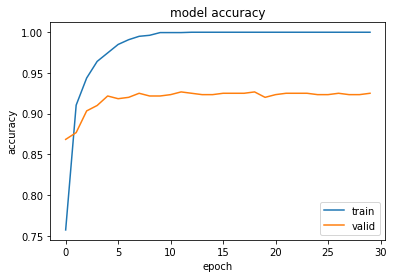

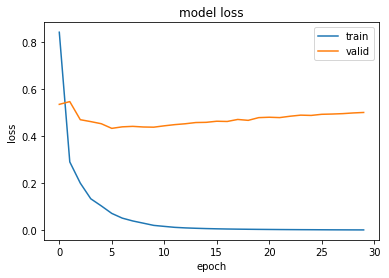

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## Prediction on the normalized test set


In [25]:
X_test_norm = np.array((X_test - X_mean ) / (X_std + 0.0001),dtype="float32")
pred=model.predict(X_test_norm)
print(confusion_matrix(Y_test,np.argmax(pred,axis=1)))
print("Acc = " ,np.sum(Y_test==np.argmax(pred,axis=1))/len(pred))

[[ 83   0   1   0   0   0   1   0   0   0]
 [  0 124   0   1   0   0   1   0   0   0]
 [  1   2 102   2   0   0   0   3   4   2]
 [  1   2   1  90   0   7   1   2   1   2]
 [  1   1   0   0 101   0   1   0   0   6]
 [  1   0   1   1   3  76   1   1   1   2]
 [  2   0   1   0   2   3  79   0   0   0]
 [  0   2   2   2   0   1   0  89   0   3]
 [  2   0   2   2   4   0   0   2  77   0]
 [  0   0   1   1   0   0   0   3   0  89]]
Acc =  0.91


In [26]:
#!tensorboard --logdir=tensorboard/tensorboard/mnist/